# Matt data (sefi subsample 1)

In [1]:
import pysam
import pandas as pd
import numpy as np 
from tqdm import tqdm
from matplotlib import pyplot as plt
import collections
import Levenshtein
import upsetplot

import analysis_functions as af


## Cellranger metrics

In [2]:
cr_filtered_bc = []
with open('matt-data_cellranger_whitelist.tsv', 'r') as f:
    for l in f:
        cr_filtered_bc.append(l.split('-')[0])
cr_filtered_bc = set(cr_filtered_bc)        

In [3]:
# # get cell ranger matrix
# class cr_matrix:
#     def __init__(self, mat_file):
#         self.mat = af.get_matrix_from_h5(mat_file)
    
#     def get_barcode_umi_count(self):
#         '''
#         Get the barcode umi count (columns sum) of the matrix
#         return:
#             np.array
#         '''
#         return np.array(self.mat.matrix.sum(0)).reshape(-1)
#     def get_barcode_str(self, as_str = True):
#         '''
#         get the barcode stored in the matrix.hs
        
#         Option:
#             as_str: <bool> whether convert the barcode to str (True by default)
#         return:
#             np.array of barcodes
#         '''
#         if as_str:
#             return np.array([x.decode('UTF-8').split('-')[0] for x in self.mat.barcodes])
#         else:
#             return self.mat.barcodes

# filtered_matrix_h5 = "/home/ubuntu/vol_data/project/SC_analysis/analysis/Cellranger/output/sefi_sup_1/outs/filtered_feature_bc_matrix.h5"
# raw_matrix_h5 = "/home/ubuntu/vol_data/project/SC_analysis/analysis/Cellranger/output/sefi_sup_1/outs/raw_feature_bc_matrix.h5"


# filtered_feature_bc_matrix = cr_matrix(filtered_matrix_h5)
# raw_feature_bc_matrix = cr_matrix(raw_matrix_h5)

In [4]:
# cr_filtered_bc = set(filtered_feature_bc_matrix.get_barcode_str())
# cr_count_d = pd.DataFrame({
#     "BC": raw_feature_bc_matrix.get_barcode_str(),
#     "counts": raw_feature_bc_matrix.get_barcode_umi_count()
# })


In [5]:
# cr_count_d['is_cell'] = cr_count_d.BC.isin(cr_filtered_bc)
# cr_count_d = cr_count_d.sort_values(by=['counts'], ascending = False).reset_index()


In [6]:
# # Barcode rand plot

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# x = sorted(cr_count_d[cr_count_d.is_cell].counts, reverse=True)
# ax1.loglog(np.array(x), marker = 'o', linestyle="")
# ax1.set_xlabel('Barcodes')
# ax1.set_ylabel('UMI counts')
# ax1.set_title('Barcode rank plot (Cellranger filter barcodes)')
# #ax1.set_xlim(1,1000000)

# x2 = sorted(cr_count_d.counts, reverse=True)
# ax2.loglog(np.array(x2),marker = 'o',linestyle="")
# ax2.loglog(np.array(x),marker = 'o', linestyle="")
# ax2.set_xlabel('Barcodes')
# ax2.set_ylabel('UMI counts')
# ax2.set_title('Barcode rank plot (Cellranger raw barcodes)')
# ax2.set_xlim(1,1000000)
# fig.show()


## BLAZE (Q20 and non-Q20)

### 10X BC

In [7]:
whole_whitelist = []
with open("../3M-february-2018.txt", 'r') as f:
    for line in f:
        whole_whitelist.append(line.strip())
whole_whitelist = set(whole_whitelist)

### Thresholding strategy

In [8]:
raw_bc_d = pd.read_csv('matt-data_blaze_raw_bc.csv')

In [89]:
# temp threshold for minQ
def tune_minQ(minQ, d):
    raw_bc_d_HQ = d[d.raw_bc_min_q >= minQ].raw_bc.value_counts().to_frame()
    raw_bc_d_HQ['bc_rank'] = list(range(1,len(raw_bc_d_HQ)+1))
    raw_bc_d_HQ.reset_index(inplace=True)
    raw_bc_d_HQ = raw_bc_d_HQ.rename(columns = {'index':'BC', 'raw_bc':'counts'})
    rst_d = raw_bc_d_HQ[raw_bc_d_HQ.BC.isin(whole_whitelist)]
    rst_d.reset_index(inplace=True)
    print(rst_d.counts.sum())
    return rst_d

In [90]:
raw_bc_d_minQ15_filtered = tune_minQ(15, d = raw_bc_d)

8125333


#### Quantile (95-percentile of top N cell / 20)

In [101]:
# 99-percentile of top N cell / 10
def percentile_count_thres(count_array, exp_cells=None):
    if exp_cells:
        top_count = np.sort(count_array)[::-1][:exp_cells]
        return np.quantile(top_count, 0.95)/20
    else:
        exp_cells = 0
        new_exp_cells = int(len(count_array)/2)
        count_array = np.sort(count_array)[::-1]
        while exp_cells != new_exp_cells:  
            exp_cells = new_exp_cells
            
            top_count = count_array[:exp_cells]
            t = np.quantile(top_count, 0.95)/20

            new_exp_cells = (count_array >= t).sum()
            print(exp_cells,new_exp_cells, t)
        return t
def getKneeDistance(values):
    import numpy.matlib as npm
    """
    This function is based on
    https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    and https://dataplatform.cloud.ibm.com/analytics/notebooks/54d79c2a-f155-40ec-93ec-ed05b58afa39/view?access_token=6d8ec910cf2a1b3901c721fcb94638563cd646fe14400fecbb76cea6aaae2fb1
    The idea is to draw a line from the first to last point on the
    cumulative counts curve and then find the point on the curve
    which is the maximum distance away from this line
    """

    # get coordinates of all the points
    nPoints = len(values)
    allCoord = np.vstack((range(nPoints), values)).T

    # get the first point
    firstPoint = allCoord[0]
    # get vector between first and last point - this is the line
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec ** 2))

    # find the distance from each point to the line:
    # vector between all points and first point
    vecFromFirst = allCoord - firstPoint

    # To calculate the distance to the line, we split vecFromFirst into two
    # components, one that is parallel to the line and one that is perpendicular
    # Then, we take the norm of the part that is perpendicular to the line and
    # get the distance.
    # We find the vector parallel to the line by projecting vecFromFirst onto
    # the line. The perpendicular vector is vecFromFirst - vecFromFirstParallel
    # We project vecFromFirst by taking the scalar product of the vector with
    # the unit vector that points in the direction of the line (this gives us
    # the length of the projection of vecFromFirst onto the line). If we
    # multiply the scalar product by the unit vector, we have vecFromFirstParallel

    scalarProduct = np.sum(vecFromFirst * npm.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel

    # distance to line is the norm of vecToLine
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))

    # knee/elbow is the point with max distance value
    idxOfBestPoint = np.argmax(distToLine)

    return distToLine, idxOfBestPoint

threshold = percentile_count_thres(raw_bc_d_minQ15_filtered.counts,500)

In [102]:
bc_pass_idx = raw_bc_d_minQ15_filtered.counts >= threshold
passed_bc = set(raw_bc_d_minQ15_filtered[bc_pass_idx].BC)
correct = len(passed_bc & cr_filtered_bc)
print(
f'''
    passed BC: {len(passed_bc)}
    correct: {correct}
''')



    passed BC: 188
    correct: 188



(182.0, 200.0)

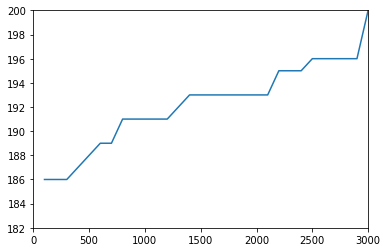

In [93]:

plt.plot(x,y)
plt.xlim(0,3000)
plt.ylim(182,200)

100%|████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 148.83it/s]


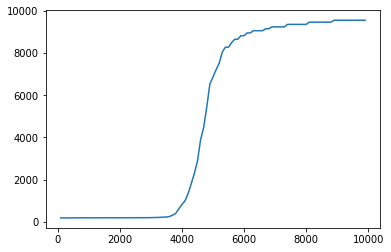

In [94]:
# robustness of expected cell
x = np.arange(100, 10000, 100)
y = []

for t in tqdm(x):
    threshold = percentile_count_thres(raw_bc_d_minQ15_filtered.counts,t)
    y.append(sum(raw_bc_d_minQ15_filtered.counts >= threshold))

plt.plot(x,y)



In [103]:
# knee point:
import kneed
def find_knee_point(counts):
    counts = np.array(counts)
    counts = counts[counts > 0]
    counts = sorted(counts)[::-1]
    kneedle  = kneed.KneeLocator(y =np.cumsum(counts),x = range(len(counts)),  S=1.0, curve="concave", direction="increasing")
    return kneedle.knee

_, top_n = getKneeDistance(list(raw_bc_d_minQ15_filtered.counts))
threshold_2 = list(raw_bc_d_minQ15_filtered.counts)[top_n]
passed_bc = set(raw_bc_d_minQ15_filtered.iloc[:top_n,].BC)
correct = len(passed_bc & cr_filtered_bc)
print(
f'''
    passed BC: {len(passed_bc)}
    correct: {correct}
''')



    passed BC: 334
    correct: 247



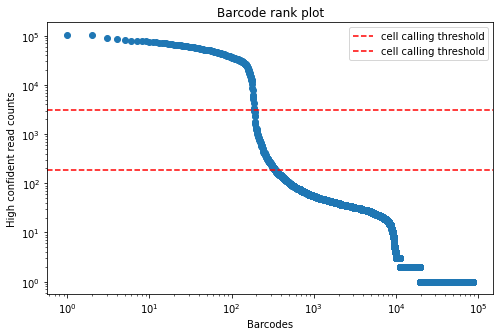

In [104]:
# Barcode rank plot
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.loglog(raw_bc_d_minQ15_filtered.counts, marker="o", linestyle="")

ax.set_xlabel('Barcodes')
ax.set_ylabel('High confident read counts')
ax.set_title('Barcode rank plot')
ax.axhline(y=threshold, color='r', linestyle='--', label = 'cell calling threshold')
ax.axhline(y=threshold_2, color='r', linestyle='--', label = 'cell calling threshold')
ax.legend()

fig.show()

### BLAZE vs cellrange BC

In previous section, cellranger found 1036 cells from short reads and we found  {{len(passed_bc_q20)}} (Q20 data) and  {{len(passed_bc_nonq20)}} (non-Q20 data).

In this section, we highlight:
    The cell barcode found by Cellranger but not by BLAZE

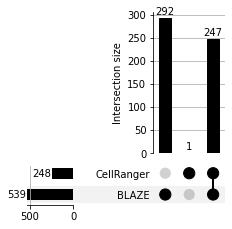

In [15]:
# Agreement BLAZE and cellranger
from upsetplot import from_contents
a = from_contents({'BLAZE':passed_bc, 'CellRanger':cr_filtered_bc})
upsetplot.plot(a, show_counts=True)
plt.show()

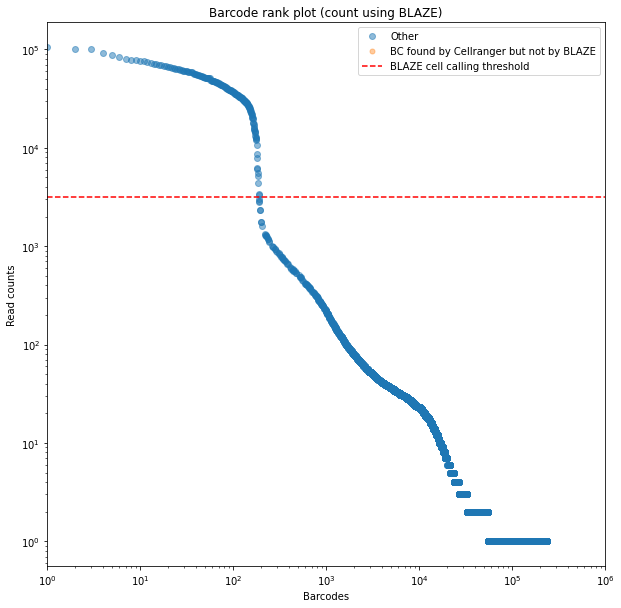

In [16]:
# On BLAZE knee plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
highlight_set = cr_filtered_bc - passed_bc
label_text = 'BC found by Cellranger but not by BLAZE'
ax1.set_title('Barcode rank plot (count using BLAZE)')
ax1.loglog(raw_bc_d_minQ15_filtered[~raw_bc_d_minQ15_filtered.BC.isin(highlight_set)].bc_rank,
           raw_bc_d_minQ15_filtered[~raw_bc_d_minQ15_filtered.BC.isin(highlight_set)].counts,
           marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
ax1.loglog(raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(highlight_set)].bc_rank/1.1,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(highlight_set)].counts,
           marker = 'o', linestyle="", label=label_text, alpha = 0.4, markersize = 5)

ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
ax1.legend()
ax1.set_xlabel('Barcodes')
ax1.set_ylabel('Read counts')
ax1.set_xlim(1,1000000)
fig.show()


## Some other ideas about finding BC (BLAZE) (unfinished)

### Test 1
* Step 1: finding BC with high count of confident raw BC (minQ > 15)
* Step 2: assign some BC with count slightly below the threshold (the regions that Cellranger check the expression) to the list from step 1
* Step 3: relax the threshold from step 1


In [17]:
# # test non Q20 minQ15
# temp_d = tune_minQ(10, raw_bc_d_nonq20)
# s1_list = temp_d.BC[temp_d.counts > 1000]
# s2_list_raw = temp_d.BC[(temp_d.counts > 50) & (temp_d.counts <= 1000)]

# # check ED
# min_ed = []
# for bc2 in tqdm(s2_list_raw):
#     min_ed.append(min([Levenshtein.distance(x, bc2) for x in s1_list]))
    
# print(len(s2_list_raw))
# print([x in cr_bc_list for x in np.array(s2_list_raw)[np.where(np.array(min_ed)==1)]])
# print([x in cr_bc_list for x in np.array(s2_list_raw)[np.where(np.array(min_ed)==2)]])
# print([x in cr_bc_list for x in np.array(s2_list_raw)[np.where(np.array(min_ed)==3)]])
# print([x in cr_bc_list for x in np.array(s2_list_raw)[np.where(np.array(min_ed)==4)]])

In [18]:
# # test non Q20 minQ15
# s1_list = raw_bc_d_nonq20_HQ_filtered.BC[raw_bc_d_nonq20_HQ_filtered.counts > 1000]
# s2_list_raw = raw_bc_d_nonq20_HQ_filtered.BC[(raw_bc_d_nonq20_HQ_filtered.counts > 50) & (raw_bc_d_nonq20_HQ_filtered.counts <= 1000)]

# # check ED
# min_ed = []
# for bc2 in tqdm(s2_list_raw):
#     min_ed.append(min([Levenshtein.distance(x, bc2) for x in s1_list]))
    
# print(len(s2_list_raw))
# print([x in cr_bc_list for x in np.array(s2_list_raw)[np.where(np.array(min_ed)==1)]])
# print([x in cr_bc_list for x in np.array(s2_list_raw)[np.where(np.array(min_ed)==2)]])


## Sockeye

### Loading sockeye whitelist and check the agreement

In [19]:
# load sockeye whitelist
sock_whitelist = 'matt-data_sockeye_whitelist.tsv'
sock_whitelist = set(pd.read_csv(sock_whitelist, header = None)[0])

# sockeye raw count
sock_count = 'matt-data_sockeye_uncorrected_bc_counts.tsv'
sock_count = pd.read_csv(sock_count, header = None, sep = '\t', names = ['BC', 'counts'])

# sort the count
sock_count = sock_count.sort_values(by=['counts'], ascending = False)

### Overlap BLAZE x Sockeye x Cellranger

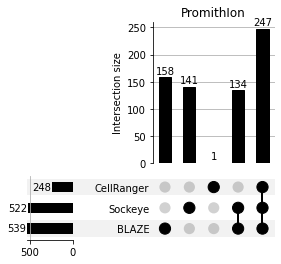

In [20]:
# upset plot
from upsetplot import from_contents

a = from_contents({'BLAZE':passed_bc, 
                   'Sockeye':sock_whitelist, 
                   'CellRanger':cr_filtered_bc})
upsetplot.plot(a, show_counts=True)
plt.title("PromithIon")
plt.show()


I plot the following three categories:
* Cat1: Found by Sockeye only
* Cat2: Found by CellRanger only
* Cat3: Found by Sockeye and CellRanger but not BLAZE
* Cat4: Found by all of three methods

15281761


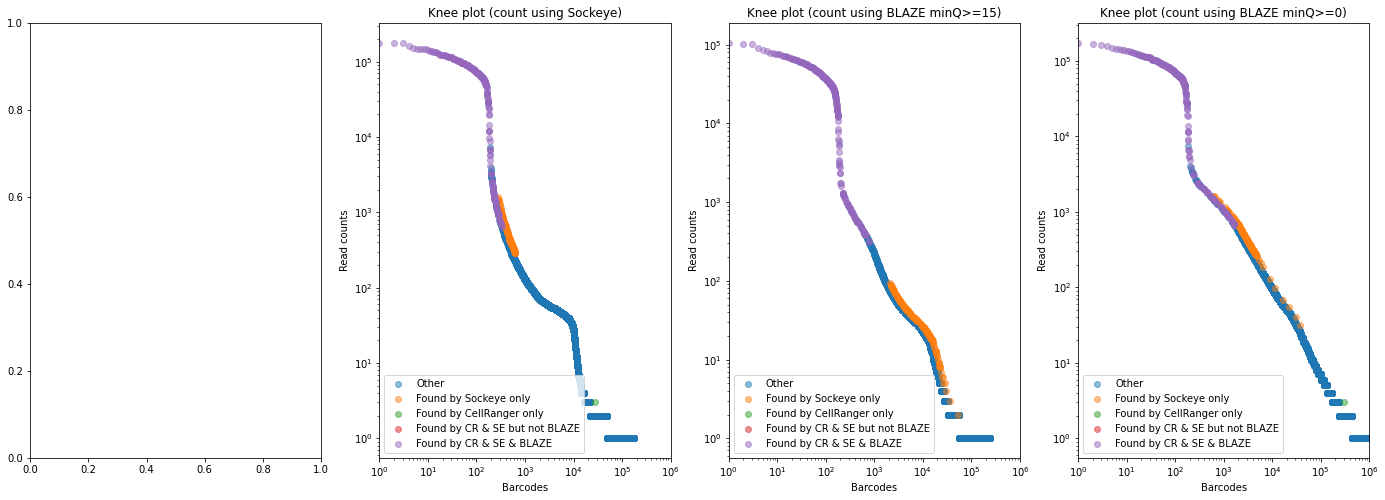

In [21]:
# 4 categories of cells on  range plot from three methods
cat1 = sock_whitelist-cr_filtered_bc-passed_bc
cat2 = cr_filtered_bc-sock_whitelist-passed_bc
cat3 = (cr_filtered_bc &  sock_whitelist) - passed_bc
cat4= (cr_filtered_bc &  sock_whitelist&passed_bc)
# One CellRanger Knee plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))

# ax1.set_title('Knee plot (count using CellRanger)')
# ax1.loglog(cr_count_d[~cr_count_d.BC.isin(cat1 | cat2 | cat3 | cat4)].index+1,
#            cr_count_d[~cr_count_d.BC.isin(cat1 | cat2 | cat3 | cat4)].counts,
#            marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
# ax1.loglog((cr_count_d[cr_count_d.BC.isin(cat1)].index+1)*1.2,
#            cr_count_d[cr_count_d.BC.isin(cat1)].counts,
#            marker = 'o', linestyle="", label="Found by Sockeye only",  alpha = 0.5, markersize=6)
# ax1.loglog((cr_count_d[cr_count_d.BC.isin(cat2)].index+1)*1.2**2,
#            cr_count_d[cr_count_d.BC.isin(cat2)].counts,
#            marker = 'o', linestyle="", label="Found by CellRanger only",  alpha = 0.5, markersize=6)
# ax1.loglog((cr_count_d[cr_count_d.BC.isin(cat3)].index+1)*1.2**3,
#            cr_count_d[cr_count_d.BC.isin(cat3)].counts,
#            marker = 'o', linestyle="", label="Found by CR & SE but not BLAZE",  alpha = 0.5, markersize=6)
# ax1.loglog((cr_count_d[cr_count_d.BC.isin(cat4)].index+1),
#            cr_count_d[cr_count_d.BC.isin(cat4)].counts,
#            marker = 'o', linestyle="", label="Found by CR & SE & BLAZE",  alpha = 0.5, markersize=6)
# #ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
# ax1.legend()
# ax1.set_xlabel('Barcodes')
# ax1.set_ylabel('UNI counts')
# ax1.set_xlim(1,1000000)



ax2.set_title('Knee plot (count using Sockeye)')
ax2.loglog(sock_count[~sock_count.BC.isin(cat1 | cat2 | cat3 | cat4)].index+1,
           sock_count[~sock_count.BC.isin(cat1 | cat2 | cat3 | cat4)].counts,
           marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat1)].index+1)*1.2,
           sock_count[sock_count.BC.isin(cat1)].counts,
           marker = 'o', linestyle="", label="Found by Sockeye only",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat2)].index+1)*1.2**2,
           sock_count[sock_count.BC.isin(cat2)].counts,
           marker = 'o', linestyle="", label="Found by CellRanger only",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat3)].index+1)*1.2**3,
           sock_count[sock_count.BC.isin(cat3)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE but not BLAZE",  alpha = 0.5, markersize=6)
ax2.loglog((sock_count[sock_count.BC.isin(cat4)].index+1),
           sock_count[sock_count.BC.isin(cat4)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE & BLAZE",  alpha = 0.5, markersize=6)
#ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
ax2.legend(loc = 'lower left')
ax2.set_xlabel('Barcodes')
ax2.set_ylabel('Read counts')
ax2.set_xlim(1,1000000)


ax3.set_title('Knee plot (count using BLAZE minQ>=15)')
ax3.loglog(raw_bc_d_minQ15_filtered[~raw_bc_d_minQ15_filtered.BC.isin(cat1 | cat2 | cat3 | cat4)].index+1,
           raw_bc_d_minQ15_filtered[~raw_bc_d_minQ15_filtered.BC.isin(cat1 | cat2 | cat3 | cat4)].counts,
           marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat1)].index+1)*1.2,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat1)].counts,
           marker = 'o', linestyle="", label="Found by Sockeye only",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat2)].index+1)*1.2**2,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat2)].counts,
           marker = 'o', linestyle="", label="Found by CellRanger only",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat3)].index+1)*1.2**3,
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat3)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE but not BLAZE",  alpha = 0.5, markersize=6)
ax3.loglog((raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat4)].index+1),
           raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.BC.isin(cat4)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE & BLAZE",  alpha = 0.5, markersize=6)
#ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
ax3.legend()
ax3.set_xlabel('Barcodes')
ax3.set_ylabel('Read counts')
ax3.set_xlim(1,1000000)

d_minQ0_temp = tune_minQ(0, d = raw_bc_d)
ax4.set_title('Knee plot (count using BLAZE minQ>=0)')
ax4.loglog(d_minQ0_temp[~d_minQ0_temp.BC.isin(cat1 | cat2 | cat3 | cat4)].index+1,
           d_minQ0_temp[~d_minQ0_temp.BC.isin(cat1 | cat2 | cat3 | cat4)].counts,
           marker = 'o', linestyle="", label="Other",  alpha = 0.5, markersize=6)
ax4.loglog((d_minQ0_temp[d_minQ0_temp.BC.isin(cat1)].index+1)*1.2,
           d_minQ0_temp[d_minQ0_temp.BC.isin(cat1)].counts,
           marker = 'o', linestyle="", label="Found by Sockeye only",  alpha = 0.5, markersize=6)
ax4.loglog((d_minQ0_temp[d_minQ0_temp.BC.isin(cat2)].index+1)*1.2**2,
           d_minQ0_temp[d_minQ0_temp.BC.isin(cat2)].counts,
           marker = 'o', linestyle="", label="Found by CellRanger only",  alpha = 0.5, markersize=6)
ax4.loglog((d_minQ0_temp[d_minQ0_temp.BC.isin(cat3)].index+1)*1.2**3,
           d_minQ0_temp[d_minQ0_temp.BC.isin(cat3)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE but not BLAZE",  alpha = 0.5, markersize=6)
ax4.loglog((d_minQ0_temp[d_minQ0_temp.BC.isin(cat4)].index+1),
           d_minQ0_temp[d_minQ0_temp.BC.isin(cat4)].counts,
           marker = 'o', linestyle="", label="Found by CR & SE & BLAZE",  alpha = 0.5, markersize=6)
#ax1.axhline(y=threshold, color='r', linestyle='--', label = 'BLAZE cell calling threshold')
ax4.legend()
ax4.set_xlabel('Barcodes')
ax4.set_ylabel('Read counts')
ax4.set_xlim(1,1000000)

fig.show()

del d_minQ0_temp


### Checking the base quality for different categories

#### minQ distribution for all raw BC in different categories

/home/ubuntu/vol_data/miniconda3/envs/analysis/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


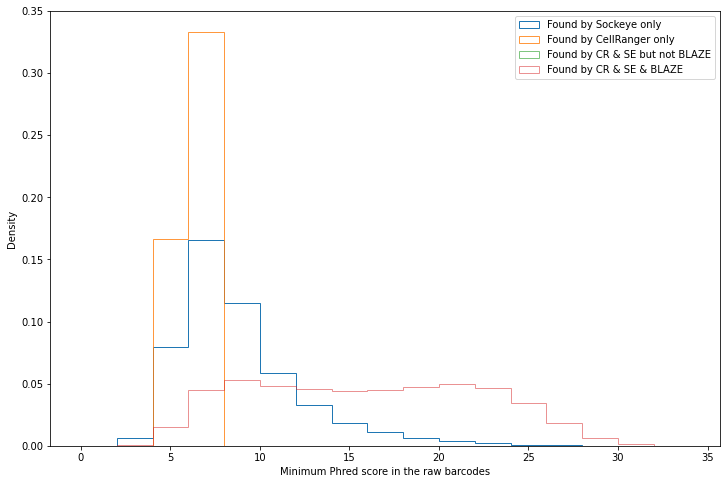

In [22]:
# per read
cat1 = sock_whitelist-cr_filtered_bc-passed_bc
cat2 = cr_filtered_bc-sock_whitelist-passed_bc
cat3 = (cr_filtered_bc &  sock_whitelist) - passed_bc
cat4= (cr_filtered_bc &  sock_whitelist&passed_bc)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# based on BLAZE raw_bc.tsv
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat1)].raw_bc_min_q, density= True, alpha = 1, histtype='step', 
         bins=np.arange(0,35,2), label = "Found by Sockeye only")
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat2)].raw_bc_min_q, density= True, alpha = 0.8 ,histtype='step',
        bins=np.arange(0,35,2), label = "Found by CellRanger only")
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat3)].raw_bc_min_q, density= True, alpha = 0.6,histtype='step',
        bins=np.arange(0,35,2), label = "Found by CR & SE but not BLAZE")
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat4)].raw_bc_min_q, density= True, alpha = 0.5, histtype='step',
        bins=np.arange(0,35,2), label = "Found by CR & SE & BLAZE")
ax1.set_ylabel('Density')
ax1.set_xlabel('Minimum Phred score in the raw barcodes')
ax1.legend()
ax1.set_title('')
fig.show()


#### average minQ distribution for cell in different categories (unit is cell)

/home/ubuntu/vol_data/miniconda3/envs/analysis/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


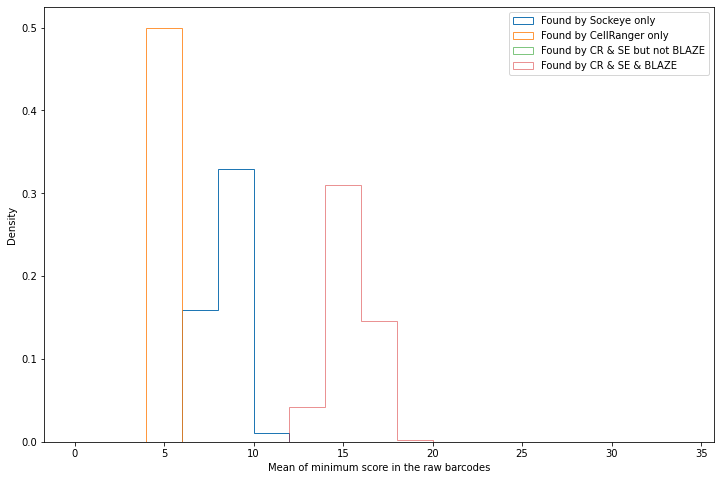

In [23]:
# per cell
cat1 = sock_whitelist-cr_filtered_bc-passed_bc
cat2 = cr_filtered_bc-sock_whitelist-passed_bc
cat3 = (cr_filtered_bc &  sock_whitelist) - passed_bc
cat4= (cr_filtered_bc &  sock_whitelist&passed_bc)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# based on BLAZE raw_bc.tsv
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat1)].groupby(by=['raw_bc']).raw_bc_min_q.mean(), density= True, alpha = 1, histtype='step', 
         bins=np.arange(0,35,2), label = "Found by Sockeye only")
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat2)].groupby(by=['raw_bc']).raw_bc_min_q.mean(), density= True, alpha = 0.8 ,histtype='step',
        bins=np.arange(0,35,2), label = "Found by CellRanger only")
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat3)].groupby(by=['raw_bc']).raw_bc_min_q.mean(), density= True, alpha = 0.6,histtype='step',
        bins=np.arange(0,35,2), label = "Found by CR & SE but not BLAZE")
ax1.hist(raw_bc_d[raw_bc_d.raw_bc.isin(cat4)].groupby(by=['raw_bc']).raw_bc_min_q.mean(), density= True, alpha = 0.5, histtype='step',
        bins=np.arange(0,35,2), label = "Found by CR & SE & BLAZE")
ax1.set_ylabel('Density')
ax1.set_xlabel('Mean of minimum score in the raw barcodes')
ax1.legend()
ax1.set_title('')
fig.show()


## PRC plot

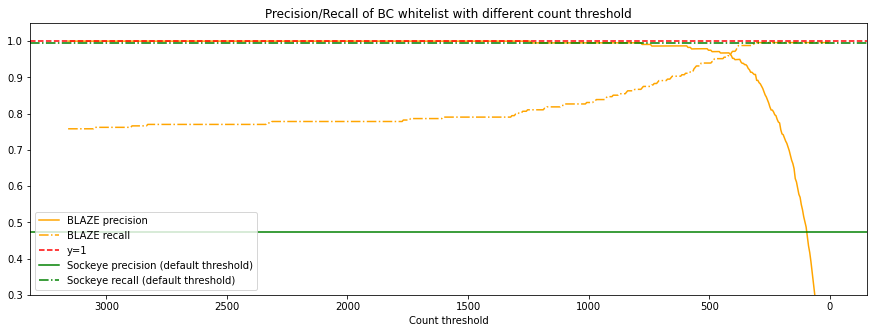

In [24]:

fig, ax = plt.subplots(1,1, figsize = (15,5))

precision = []
recall = []
x = np.arange(threshold, 0, -5)
for T in x:
    passed_bc = raw_bc_d_minQ15_filtered[raw_bc_d_minQ15_filtered.counts>T].BC
    correct = len(set(passed_bc) & set(cr_filtered_bc))
    total = len(set(cr_filtered_bc))
    detected = len(passed_bc)
    precision.append(correct/detected)
    recall.append(correct/total)
ax.plot(x, precision, label = 'BLAZE precision', linestyle='solid',color = 'orange')
ax.plot(x, recall, label = 'BLAZE recall',linestyle='dashdot',color = 'orange')
ax.axhline(y=1, label='y=1', color='r', linestyle='--')
ax.set_xlabel('Count threshold')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(0.3,1.05)
ax.axhline(y=247/522, label='Sockeye precision (default threshold)', color='green', linestyle='solid')
ax.axhline(y=247/248, label='Sockeye recall (default threshold)', color='green', linestyle='dashdot')
ax.set_title('Precision/Recall of BC whitelist with different count threshold')
ax.legend()

fig.show()

In [29]:
len(cr_filtered_bc)

248

In [57]:
sock_count[sock_count.BC.isin(cr_filtered_bc)]

,BC,counts
0,CTCCGATCATGGCCAC,177979
1,TTACCATCATGTCAGT,175425
2,CATCGCTCAAGTAGTA,175123
3,AGCGCCACAATCCAGT,163141
4,ATGCCTCGTCAAGCCC,153037
...,...,...
312,GAAGCCCAGCGTGCCT,725
319,ACTTTCATCATACGGT,692
321,TCTGTCGCATGGCACC,686
332,ACGGGTCCACTTCAGA,647


In [66]:
from sklearn.metrics import precision_recall_curve

#calculate precision and recall
# add count 0 for true BC if not exsit in the df

# blaze
missing_bc =  [1]* len(cr_filtered_bc - set(raw_bc_d_minQ15_filtered.BC))
missing_bc_count = [0] * len(missing_bc)
blaze_pre,blaze_recall , blaze_thresholds =\
                            precision_recall_curve([int(x in cr_filtered_bc) for x in raw_bc_d_minQ15_filtered.BC] + missing_bc,
                                                   list(raw_bc_d_minQ15_filtered.counts) + missing_bc_count)

missing_bc =  [1]* len(cr_filtered_bc - set(sock_count.BC))
missing_bc = [1] * len(missing_bc)
missing_bc_count = [0] * len(missing_bc)
sockeye_pre,sockeye_recall , sockeye_thresholds =\
                            precision_recall_curve([int(x in cr_filtered_bc) for x in sock_count.BC] + missing_bc,
                                                   list(sock_count.counts)+missing_bc_count)





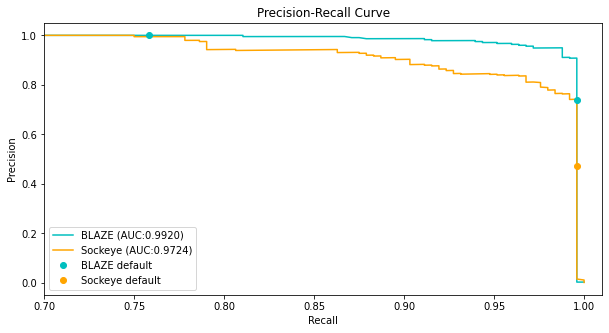

In [106]:
from sklearn.metrics import auc
#create precision recall curve
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(blaze_recall, blaze_pre, 
        label = f'BLAZE (AUC:{auc(blaze_recall,blaze_pre):.4f})', color='c')

ax.plot(sockeye_recall, sockeye_pre, 
        label = f'Sockeye (AUC:{auc(sockeye_recall, sockeye_pre):.4f})', color='orange')
ax.plot([188/248, 247/248],[188/188, 247/334], label='BLAZE default', marker = 'o', linestyle='', color='c') 
ax.plot(247/248,247/522, label='Sockeye default', marker = 'o', linestyle='', color='orange') 
#add axis labels to plot
ax.legend()
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_xlim(0.7,1.01)

#display plot
plt.show()

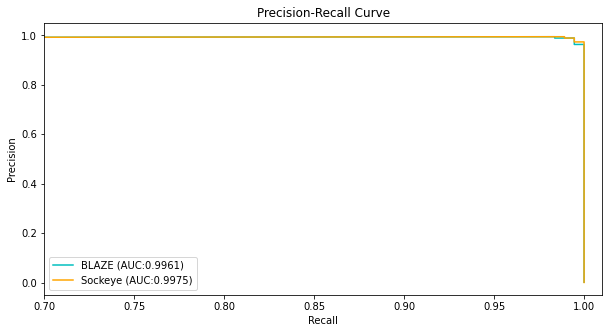

In [107]:
cr_filtered_bc_ground_true = set([x.strip() for x in open('matt_data_groundtrue.csv')])
#calculate precision and recall
# add count 0 for true BC if not exsit in the df

# blaze
missing_bc =  [1]* len(cr_filtered_bc_ground_true - set(raw_bc_d_minQ15_filtered.BC))
missing_bc_count = [0] * len(missing_bc)
blaze_pre,blaze_recall , blaze_thresholds =\
                            precision_recall_curve([int(x in cr_filtered_bc_ground_true) for x in raw_bc_d_minQ15_filtered.BC] + missing_bc,
                                                   list(raw_bc_d_minQ15_filtered.counts) + missing_bc_count)

missing_bc =  [1]* len(cr_filtered_bc_ground_true - set(sock_count.BC))
missing_bc = [1] * len(missing_bc)
missing_bc_count = [0] * len(missing_bc)
sockeye_pre,sockeye_recall , sockeye_thresholds =\
                            precision_recall_curve([int(x in cr_filtered_bc_ground_true) for x in sock_count.BC] + missing_bc,
                                                   list(sock_count.counts)+missing_bc_count)

from sklearn.metrics import auc
#create precision recall curve
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(blaze_recall, blaze_pre, 
        label = f'BLAZE (AUC:{auc(blaze_recall,blaze_pre):.4f})', color='c')

ax.plot(sockeye_recall, sockeye_pre, 
        label = f'Sockeye (AUC:{auc(sockeye_recall, sockeye_pre):.4f})', color='orange')
# ax.plot([801/1036, 899/1036],[801/804, 899/1139],label='BLAZE default', marker = 'o', linestyle='', color='c') 
# ax.plot(882/1036,882/1518, label='Sockeye default', marker = 'o', linestyle='', color='orange') 
#add axis labels to plot
ax.legend()
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_xlim(0.7,1.01)

#display plot
plt.show()